In [15]:
from pathlib import Path
import random
import json

import yaml
import cv2
import matplotlib.pyplot as plt

from models.sift.infer import SIFTDetector
from models.sift.evaluate import DetectorEvaluator
from models.sift.model_utils import visualize_case

In [16]:
# TODO: Retrieve-Reconstruct Fialures
# TODO: Sample and Visualise Results with IoU
# TODO: Implement Runs

In [21]:
# -- LOADERS -- #
def load_dataset(config, skip_class_names=None):
    """
    Load dataset from config paths, skipping classes by their names
    """
    # Get root paths
    project_root = Path(config['paths']['project_root'])
    data_root = project_root / config['paths']['data_root']
    
    # Load annotations
    ann_path = data_root / config['data']['annotations_path']
    with open(ann_path, 'r') as f:
        annotations = json.load(f)
    
    # Update image paths to full paths
    img_root = data_root / config['data']['img_root']
    for img in annotations['images']:
        img['file_name'] = str(img_root / img['file_name'])
    
    if skip_class_names:
        # Create mapping of names to IDs
        name_to_id = {cat['name']: cat['id'] for cat in annotations['categories']}
        
        # Convert names to IDs
        skip_class_ids = [name_to_id[name] for name in skip_class_names]
        
        # Filter annotations
        annotations['annotations'] = [
            ann for ann in annotations['annotations']
            if ann['category_id'] not in skip_class_ids
        ]
    
    # Process annotations
    imgs = annotations['images']
    ann_dict = {}
    for ann in annotations['annotations']:
        img_id = ann['image_id']
        if img_id not in ann_dict:
            ann_dict[img_id] = []
        ann_dict[img_id].append(ann)
    
    return imgs, ann_dict

def load_templates(config):
    """Load template images from config"""
    project_root = Path(config['paths']['project_root'])
    data_root = project_root / config['paths']['data_root']
    
    templates = {
        class_id: cv2.imread(str(data_root / path), cv2.IMREAD_GRAYSCALE)
        for class_id, path in config['model']['template_paths'].items()
    }
    
    # Verify all templates were loaded
    failed_templates = [class_id for class_id, img in templates.items() if img is None]
    if failed_templates:
        raise ValueError(f"Failed to load templates for classes: {failed_templates}")
        
    return templates

In [22]:
# -- CONFIG -- #
with open('models/sift/sift_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

imgs, annotations = load_dataset(config, skip_class_names=['nectar_price_lozenge'])

templates = {
    class_id: cv2.imread(
        str(Path(config['paths']['project_root']) / config['paths']['data_root'] / path), 
        cv2.IMREAD_GRAYSCALE
    )
    for class_id, path in config['model']['template_paths'].items()
}

In [23]:
# -- INTIT MODEL -- #
detector = SIFTDetector(templates)
evaluator = DetectorEvaluator(iou_threshold=config["evaluation"]["iou_threshold"])

In [24]:
metrics, failures = evaluator.evaluate(
    imgs=imgs,
    annotations=annotations,
    detector_fn=detector.detect_objects,
    run_name="sift_detector"
)

2025-02-16 11:50:52,682 - INFO - Starting evaluation run: sift_detector
2025-02-16 11:50:53,109 - INFO - Detected 1 at [-1141, 1359, 1378, 1536]
2025-02-16 11:50:53,172 - INFO - Detected 2 at [1040, 1282, 354, 125]
2025-02-16 11:50:53,409 - INFO - Detected 1 at [651, 925, 159, 130]
2025-02-16 11:50:53,447 - INFO - Detected 2 at [848, 948, 212, 75]
2025-02-16 11:50:53,738 - INFO - Detected 1 at [422, 700, 47, 29]
2025-02-16 11:50:53,793 - INFO - Detected 2 at [741, 922, 305, 108]
2025-02-16 11:50:54,007 - INFO - Detected 1 at [654, 925, 160, 132]
2025-02-16 11:50:54,036 - INFO - Detected 2 at [853, 949, 212, 75]
2025-02-16 11:50:54,425 - INFO - Detected 1 at [646, 1767, 160, 132]
2025-02-16 11:50:54,470 - INFO - Detected 2 at [846, 1791, 212, 75]
2025-02-16 11:50:54,785 - INFO - Detected 1 at [696, 1204, 141, 116]
2025-02-16 11:50:54,838 - INFO - Detected 2 at [860, 1226, 195, 69]
2025-02-16 11:50:55,073 - INFO - Detected 1 at [699, 35, 148, 122]
2025-02-16 11:50:55,108 - INFO - Detecte

In [25]:
metrics

{2: {'precision': 0.9889502707792803,
  'recall': 0.9781420711576936,
  'f1': 0.9835159781278958,
  'total_predictions': 181,
  'total_ground_truth': 183},
 1: {'precision': 0.9999999935483872,
  'recall': 0.9810126520189073,
  'f1': 0.9904148291809117,
  'total_predictions': 155,
  'total_ground_truth': 158}}

In [29]:
print(len(failures))
failures

7


defaultdict(<function models.sift.evaluate.DetectorEvaluator.evaluate.<locals>.<lambda>()>,
            {7: {'false_positives': [[63, 1107, 416, 236]],
              'false_negatives': [[735.1443850267381,
                1768.0427807486633,
                271.0588235294117,
                88.29946524064162]],
              'low_iou': []},
             107: {'false_positives': [],
              'false_negatives': [[815.2173913043479,
                49.56521739130433,
                217.82608695652198,
                187.8260869565217]],
              'low_iou': []},
             170: {'false_positives': [],
              'false_negatives': [[1240.2994652406417,
                1763.9358288770052,
                160.29946524064167,
                114.99465240641703]],
              'low_iou': []},
             173: {'false_positives': [],
              'false_negatives': [[314.34782608695656,
                273.9130434782609,
                10.434782608695622,
                1

In [39]:
print(f"Number of images with failures: {len(failures)}")

# Look at a sample failure
sample_id = list(failures.keys())[0]

def case_iterator(failures, imgs):
    for img_id, failure_data in failures.items():
        if failure_data['false_positives'] or failure_data['false_negatives']:
            img_data = next((img for img in imgs if img['id'] == img_id), None)
            if img_data:
                yield img_data, failure_data

# Create the iterator
failure_iter = case_iterator(failures, imgs)

Number of images with failures: 7


Image ID: 187
False positives: 1
False negatives: 1


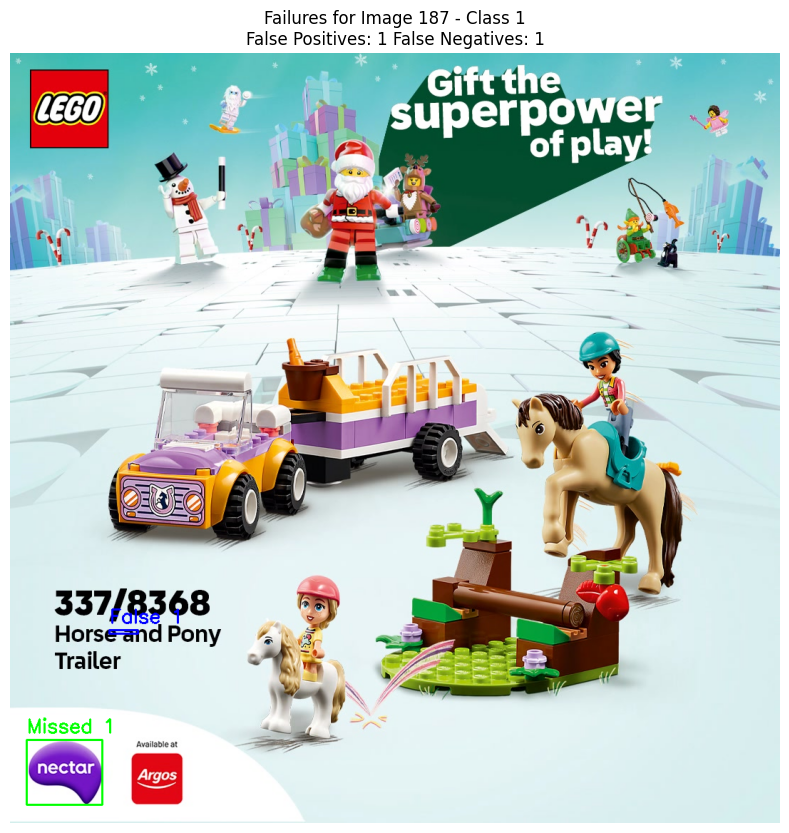

In [44]:
try:
    img_data, failure_data = next(failure_iter)
    print(f"Image ID: {img_data['id']}")
    print(f"False positives: {len(failure_data['false_positives'])}")
    print(f"False negatives: {len(failure_data['false_negatives'])}")
    visualize_case(img_data, failure_data, class_id=1)
except StopIteration:
    print("No more failures to display!")

In [34]:
# failures_ = dict(list(random.sample(failures.items(), 7)))

for class_id in failures.keys():
    if class_id == 0:
        print(f"\nAnalyzing failures for class {class_id}")
        
        # Find images with failures for this class
        for img_idx, failure_data in failures.items():
            if (len(failure_data['false_positives']) > 0 or 
                len(failure_data['false_negatives']) > 0):
                
                # Find corresponding image data
                img_data = next((img for img in imgs if img['id'] == img_idx), None)
                if img_data is None:
                    print(f"Warning: Could not find image data for index {img_idx}")
                    continue
                
                visualize_case(img_data, failure_data, class_id)